In [1]:
# Requires the following packages: seaborn, pandas, pandas_datareader, matplotlib
import lpa
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../datasets/finance/')
from finance_dataset import get_dataset
sys.path.insert(0, '../datasets/')
import plot_tools as pt
reload(pt)

<module 'plot_tools' from '../datasets/plot_tools.pyc'>

In [2]:
T_train,X_train,T_val,X_val,T_test,X_test,stock_info = get_dataset()

Number of companies: 2610


../datasets/finance/finance_dataset.py:87: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  for i in range(X.shape[0])])


Extracted 2125 companies for analysis
Extracted 2102 companies for further analysis


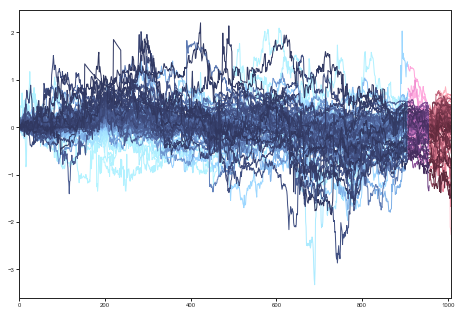

In [3]:
# Lets plot the data over time
m = X_train.shape[0]
idx_to_plot = range(1,m,20)

sort_idx = np.argsort(X_train[idx_to_plot,200], axis=0)

ax = pt.plot_series(T_train, X_train[idx_to_plot,:], linewidth=1, sort_idx=sort_idx)
ax = pt.plot_series(T_val, X_val[idx_to_plot,:], linewidth=1, sort_idx=sort_idx, ax=ax, theme='purple')
ax = pt.plot_series(T_test, X_test[idx_to_plot,:], linewidth=1, sort_idx=sort_idx, ax=ax, theme='red')

plt.xlim(T_train[0],T_test[-1])
plt.show()

In [64]:
# Let's fit a standard vector autoregressive model
n_lags = 4
va = lpa.VAR(n_lags)
va.fit(X_train)
train_err = va.one_step_rmse(X_train)
val_err = va.one_step_rmse(X_val)

print('Training error: '+"{0:05f}".format(train_err))
print('Validation error: '+"{0:05f}".format(val_err))

Training error: 0.000000
Validation error: 9.485151


In [ ]:
n_components = 100
n_lags = 1
lp = lpa.LPA(n_components,n_lags,verbose=True,basis='causal',approximate=False,n_seed=1,basis_opts={'kappa':10.,'max_iter':1000})
X_lat = lp.fit_predict_latent(X_train)
train_err = lp.one_step_rmse(X_train)
val_err = lp.one_step_rmse(X_val)

print('Training error: '+"{0:05f}".format(train_err))
print('Validation error: '+"{0:05f}".format(val_err))

>>Extracting data from time series
>>Identifying latent processes
>> Beginning seed: 0
Iteration:      0 | loss: 168.36
Iteration:     43 | loss: 5.942
>>Rotating into causal basis
>> Beginning seed: 0
Iteration:      0 | loss: 34763.954
Iteration:    100 | loss: 31503.411
Iteration:    200 | loss: 31500.601
Iteration:    300 | loss: 31500.423
Iteration:    400 | loss: 31500.266
Iteration:    500 | loss: 31500.128
Iteration:    600 | loss: 31499.994
Iteration:    700 | loss: 31499.884
Iteration:    800 | loss: 31499.759
Iteration:    900 | loss: 31499.645
Iteration:   1000 | loss: 31499.525


In [11]:
test_err = lp.one_step_rmse(X_test)
print('Test error: '+"{0:05f}".format(test_err))

Test error: 13.653996


In [5]:
# The training error looks good. Let's optimize hyperparameters for the autoregressive model and see its performance
best_va = None
best_err = 1e64
best_params = None

for n_lags in [1,2,3,4,5]:
    va = lpa.VAR(n_lags,verbose=False)
    va.fit(X_train)
    val_err = va.one_step_rmse(X_val)
    if val_err < best_err:
        best_params = n_lags
        best_va = va
        best_err = val_err
    print val_err
print best_err

# Get the test error of the best one
test_err = best_va.one_step_rmse(X_test)
print('Test error: '+"{0:05f}".format(test_err))

12.8895970023
10.3676293314
9.76310048944
9.48510694947
9.35542783451
9.35542783451
Test error: 15.988372


In [24]:
best_lp = None
best_err = 1e64
best_params = None

for n_lags in [1,2,3,4,5]:
    for n_components in [1,10,50,100,200,300,400,500]:
        print (n_components, n_lags)
        lp = lpa.LPA(n_components,n_lags,verbose=False,basis='unstructured',n_seed=10)
        lp.fit(X_train)
        val_err = lp.one_step_rmse(X_val)
        print(val_err)
        if val_err < best_err:
            best_params = (n_components,n_lags)
            best_lp = lp
            best_err = val_err

(1, 1)
14.6953454196
(10, 1)
10.2736247986
(50, 1)
8.50909934004
(100, 1)
8.24099809794
(200, 1)
8.19201051359
(300, 1)
8.82318814048
(400, 1)
9.21406696989
(500, 1)
10.2193370658
(1, 2)
14.6993148464
(10, 2)
10.2665412161
(50, 2)
8.52722779392
(100, 2)
8.3764845593
(200, 2)
8.58522966703
(300, 2)
10.8447200848
(400, 2)
24.2400175544
(500, 2)
17.8573579461
(1, 3)
14.7001732602
(10, 3)
10.3174970302
(50, 3)
8.53877699735
(100, 3)
8.29162622618
(200, 3)
10.3195430848
(300, 3)
49.8720303295
(400, 3)
11.4440990773
(500, 3)
10.9453314523
(1, 4)
14.700316808
(10, 4)
10.3613675714
(50, 4)
8.5903463874
(100, 4)
8.4797371635
(200, 4)
15.6104871421
(300, 4)
11.1870478716
(400, 4)
10.2956748374
(500, 4)
9.88465423931
(1, 5)
14.7003838996
(10, 5)
10.420939032
(50, 5)
8.70923794896
(100, 5)
8.65146458004
(200, 5)
15.7699600264
(300, 5)
10.7451559477
(400, 5)
9.70391051843
(500, 5)
9.71229129328


In [ ]:
# Get the test error of the best one
test_err = best_lp.one_step_rmse(X_test)
print('Test error: '+"{0:05f}".format(test_err))

In [38]:
val_errs = np.array([
                    [14.6953454196,10.2736247986,8.50909934004,8.265326,8.389994,8.82318814048,9.21406696989,10.2193370658],
                    [14.6993148464,10.2665412161,8.52722779392,8.3764845593,8.58522966703,10.8447200848,24.2400175544,17.8573579461],
                    [14.7001732602,10.3174970302,8.53877699735,8.29162622618,10.3195430848,49.8720303295,11.4440990773,10.9453314523],
                    [14.700316808,10.3613675714,8.5903463874,8.4797371635,15.6104871421,11.1870478716,10.2956748374,9.88465423931],
                    [14.7003838996,10.420939032,8.70923794896,8.65146458004,15.7699600264,10.7451559477,9.70391051843,9.71229129328]])

1.6663001440900269

In [21]:
test = np.arange(10)
test[-2]

8

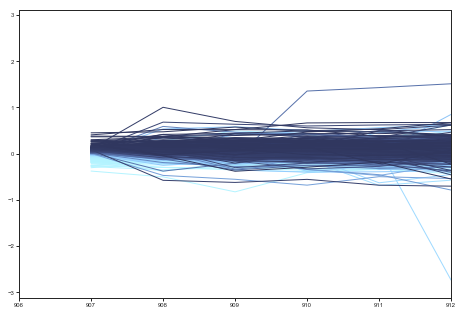

In [12]:
T_pred, X_pred, X_lat_pred = va.predict_traj(T_train,X_train,T_val[-1])

residuals = X_pred[:,1:]-X_val
pt.plot_series(T_val,residuals)
plt.xlim([T_val[0]-1,T_val[5]])
plt.show()

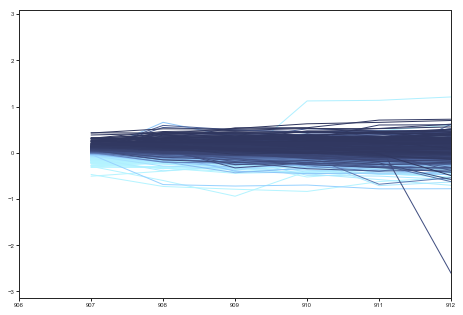

In [56]:
stds = np.std(X_train,axis=1)
T_pred, X_pred, X_lat_pred = lp.predict_traj(T_train,X_train/stds[:,np.newaxis],T_val[-1])

X_pred *= stds[:,np.newaxis]

residuals = X_pred[:,1:]-X_val
pt.plot_series(T_val,residuals)
plt.xlim([T_val[0]-1,T_val[5]])
plt.show()

In [23]:
# Let's fit a standard vector autoregressive model
n_lags = 4
va = lpa.VAR(n_lags,forward_backward=True)
va.fit(X_train)
train_err = va.one_step_rmse(X_train)
val_err = va.one_step_rmse(X_val)

ValueError: shapes (2102,1806) and (1805,8408) not aligned: 1806 (dim 1) != 1805 (dim 0)

In [8]:
# Get the test error of the best one
test_err = va.one_step_rmse(X_test)
print('Test error: '+"{0:05f}".format(test_err))

# Get the test error of the best one
test_err = lp.one_step_rmse(X_test)
print('Test error: '+"{0:05f}".format(test_err))

Test error: 16.157849
Test error: 13.960098


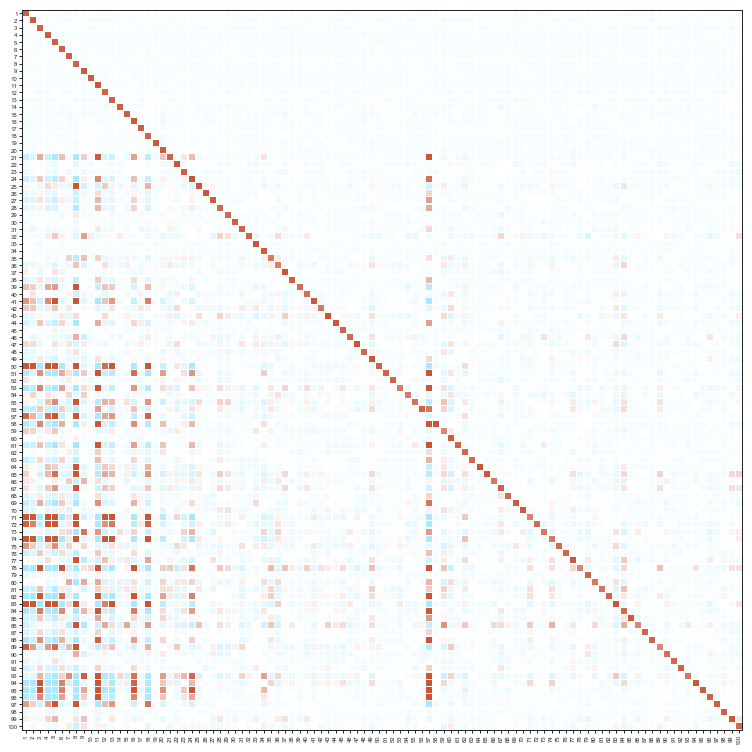

In [57]:
latent_names = range(1,n_components+1)
W,A_s,b = lp.get_model_params()
A_plot = np.mean(A_s,axis=0)
pt.heatmap(A_plot,latent_names,latent_names,cbar=False,vmin=-1,vmax=1,figsize=(10,10),theme='bwr')

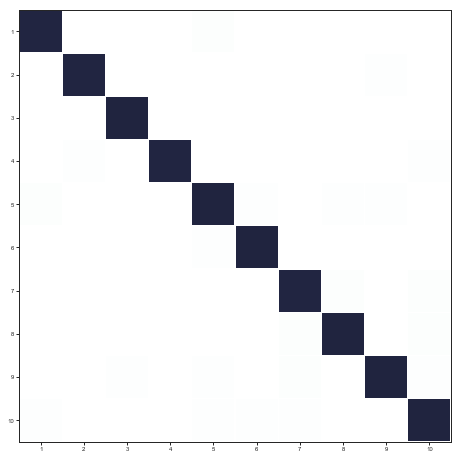

In [21]:
latent_names = range(1,n_components+1)
W,A_s,b = lp.get_model_params()
A_plot = np.abs(np.mean(A_s,axis=0))
pt.pos_heatmap(A_plot,latent_names,latent_names,cbar=False,vmin=0,vmax=1,figsize=(6,6))

In [62]:
from pprint import pprint as pp
print len(stock_info)
mean_v = np.mean(np.square(W[:,0:2]),axis=1)
s_idx = np.argsort(-mean_v)

sorted_stock_info = [[mean_v[i]]+stock_info[i] for i in s_idx]
for line in sorted_stock_info:
    print line

2102
[0.0052815895893527504, 'FVE', 'Health Care', 'Hospital/Nursing Management']
[0.0048162149258931582, 'NVGN', 'Health Care', 'Major Pharmaceuticals']
[0.0045391086243053895, 'ORMP', 'Health Care', 'Major Pharmaceuticals']
[0.0041552417416643606, 'ASUR', 'Technology', 'EDP Services']
[0.0040278300004559266, 'HCSG', 'Health Care', 'Hospital/Nursing Management']
[0.0032821706596442503, 'CLSN', 'Health Care', 'Major Pharmaceuticals']
[0.0032013352802611229, 'DGICB', 'Finance', 'Property-Casualty Insurers']
[0.0031099194531924463, 'GCBC', 'Finance', 'Banks']
[0.0030720938570722011, 'WBMD', 'Miscellaneous', 'Business Services']
[0.0030541025760002622, 'PKBK', 'Finance', 'Major Banks']
[0.0030437550197408283, 'HRTX', 'Health Care', 'Major Pharmaceuticals']
[0.0030351374718364807, 'ATRI', 'Health Care', 'Medical/Dental Instruments']
[0.0029815662802972339, 'ASML', 'Technology', 'Industrial Machinery/Components']
[0.0029791953860136798, 'BSFT', 'Technology', 'Computer Software: Prepackaged 

In [48]:
from pprint import pprint as pp
print len(stock_info)
mean_v = np.mean(np.square(W[:,0:7]),axis=1)
s_idx = np.argsort(-mean_v)

sorted_stock_info = [stock_info[i] for i in s_idx]
pp(sorted_stock_info)

2102
[['RGSE', 'Basic Industries', 'Engineering & Construction'],
 ['MRDN', 'Basic Industries', 'Miscellaneous'],
 ['HEAR', 'Consumer Durables', 'Telecommunications Equipment'],
 ['TVIA', 'Basic Industries', 'Major Chemicals'],
 ['RNVA', 'Health Care', 'Precision Instruments'],
 ['ASMB', 'Health Care', 'Major Pharmaceuticals'],
 ['NVCN', 'Health Care', 'Medical/Dental Instruments'],
 ['LEDS', 'Technology', 'Semiconductors'],
 ['SRAX', 'Technology', 'Advertising'],
 ['VIVE',
  'Health Care',
  'Biotechnology: Electromedical & Electrotherapeutic Apparatus'],
 ['GNUS', 'Consumer Services', 'Movies/Entertainment'],
 ['INVT', 'Public Utilities', 'Telecommunications Equipment'],
 ['GNVC', 'Health Care', 'Major Pharmaceuticals'],
 ['CRDS', 'Technology', 'Computer peripheral equipment'],
 ['SYMX', 'Basic Industries', 'Major Chemicals'],
 ['EGLE', 'Transportation', 'Marine Transportation'],
 ['ATOS', 'Health Care', 'Medical/Dental Instruments'],
 ['CBLI',
  'Health Care',
  'Biotechnology: Comm

In [49]:
pp(stock_info)

[['BOCH', 'Finance', 'Major Banks'],
 ['VTHR', 'n/a', 'n/a'],
 ['SGMO',
  'Health Care',
  'Biotechnology: Biological Products (No Diagnostic Substances)'],
 ['ERII', 'Technology', 'Industrial Machinery/Components'],
 ['JBHT', 'Transportation', 'Trucking Freight/Courier Services'],
 ['ERIE', 'Finance', 'Specialty Insurers'],
 ['ERIC',
  'Technology',
  'Radio And Television Broadcasting And Communications Equipment'],
 ['NRCIB',
  'Health Care',
  'Biotechnology: Commercial Physical & Biological Resarch'],
 ['PFPT', 'Technology', 'EDP Services'],
 ['KOSS', 'Consumer Non-Durables', 'Consumer Electronics/Appliances'],
 ['SCLN', 'Health Care', 'Major Pharmaceuticals'],
 ['PHMD',
  'Health Care',
  'Biotechnology: Electromedical & Electrotherapeutic Apparatus'],
 ['PTNR', 'Public Utilities', 'Telecommunications Equipment'],
 ['ALNY', 'Health Care', 'Major Pharmaceuticals'],
 ['VRTS', 'Finance', 'Investment Managers'],
 ['VRTU', 'Technology', 'EDP Services'],
 ['ITUS', 'Miscellaneous', 'Mul